# Jack's Car Rental 
#### Figure 4.2


Aditya Rastogi's blogpost 
[Elucidating Policy Iteration in Reinforcement Learning — Jack’s Car Rental Problem](https://towardsdatascience.com/elucidating-policy-iteration-in-reinforcement-learning-jacks-car-rental-problem-d41b34c8aec7)

and his repo https://github.com/thunderInfy/JacksCarRental

In [35]:
import time
import multiprocessing as mp
from math import exp, factorial, pow

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

A state is a pair of numbers of cars at the first and second location respectively. Let's define all possible states as a list of tuples:

In [34]:
# maximum car number at each location
MAX_CARS = 20
# maximal number of cars to be moved overnight
MAX_MOVE = 5
# policy evaluation accuracy
THETA = 1e-2

states = [(x, y) for x in range(MAX_CARS + 1) for y in range(MAX_CARS + 1)]

Values and policies will be dictionaries where a state is a key

In [2]:
values = dict((state, 0) for state in states)
policy = dict((state, 0) for state in states)

We'll need a function for calculationg poisson probability of getting requested and returned a certain number of cars at each location

In [7]:
from math import exp, factorial, pow

def poisson_prob(k, mu):
    """Poisson probability of getting k cars with the expectation mu"""
    return exp(-mu) * pow(mu, k) / factorial(k)

To evaluate policies we'll have to calculate probabilities for all possible numbers of requested and returned cars. There are $21^4$ possible combinations. But we can ignore some combinations as their probability is low. Let's see how probability for requested number of cars at the first location behaves:

0: 0.049787068367863944
1: 0.14936120510359183
2: 0.22404180765538775
3: 0.22404180765538775
4: 0.16803135574154082
5: 0.10081881344492448
6: 0.05040940672246225
7: 0.02160403145248382
8: 0.008101511794681432
9: 0.002700503931560477
10: 0.0008101511794681432
11: 0.00022095032167312998
12: 5.5237580418282494e-05
13: 1.2747133942680574e-05
14: 2.7315287020029804e-06
15: 5.46305740400596e-07
16: 1.0243232632511176e-07
17: 1.8076292880902075e-08
18: 3.0127154801503463e-09
19: 4.756919179184757e-10
20: 7.135378768777135e-11


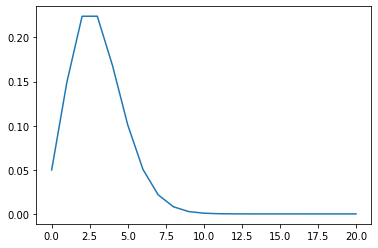

In [14]:
import matplotlib.pyplot as plt
# the expected number of requested cars in 3
y = [poisson_prob(k, 3) for k in range(21)]

plt.plot(list(range(21)), y)
for i, prob in enumerate(y):
    print(f'{i}: {prob}')

Let's set the significance level for the probability at 0.01. Possible expected numbers $\mu$ of cars  are 2, 3 and 4. The maximum number of cars that can be requested or returned with the probability higher than 0.01 are:

In [19]:
import numpy as np

for mu in (2, 3, 4):
    y = np.array([poisson_prob(k, mu) for k in range(21)])
    y1 = np.where(y > 0.01)
    print(f'if mu is {mu}, max car number is {np.max(y1)}')

if mu is 2, max car number is 6
if mu is 3, max car number is 7
if mu is 4, max car number is 9


So now lets get all pairs of requests and returns for which we shall calculate probability

In [21]:
car_requests = [(i, j) for i in range(8) for j in range(10)]
car_returns = [(i, j) for i in range(8) for j in range(7)]
requests_returns = [(i, j) for i in car_requests for j in car_returns]

Precalculate

In [22]:
poisson_prob_product = dict()
for car_request, car_return in requests_returns:
    # expectations for requested number of cars are 3 and 4 for the first and he second location respectively
    prob_request = poisson_prob(car_request[0], 3) * poisson_prob(car_request[1], 4)
    # expectations for returned number of cars are 3 and 2 for the first and he second location respectively
    prob_return = poisson_prob(car_return[0], 3) * poisson_prob(car_return[1], 2)
    poisson_prob_product[car_request, car_return] = prob_request * prob_return

 Calculate state change due to requests and returns as a separate function

In [24]:
def state_update(state, car_request, car_return):
    """State change given the number of requested and returned cars and the prize for renting cars

    :param state: state before request and return
    :type state: tuple
    :param car_request: number of cars requested at the first and the second location
    :type car_request: tuple
    :param car_return: number of cars returned at the first and the second location
    :type car_return: tuple
    :return: new state and reward for rented cars
    :rtype: tuple
    """
    # can't request more cars than available
    car_request = min(state[0], car_request[0]), min(state[1], car_request[1])

    # cars on both locations after request
    next_state = [state[0] - car_request[0], state[1] - car_request[1]]

    # get $10 for each rented car
    reward = sum(car_request) * 10

    # get returned cars, remove if their number exceeds 20
    next_state[0] = min(next_state[0] + car_return[0], 20)
    next_state[1] = min(next_state[1] + car_return[1], 20)

    return tuple(next_state), reward

In [26]:
def expected_value(values, state, action, discount=0.9):
    """Calculate expected values for a given action

    :param values: all known values so far
    :type values: dict
    :param state: state which value is updated
    :type state: tuple
    :param action: action taken in this state
    :type action: int
    :param discount: discount
    :type discount: float
    :return: new value
    :rtype: float
    """
    # move cars overnight, actions are validated during the policy improvement 
    state = min(state[0] - action, 20), min(state[1] + action, 20)
    # pay for car movement
    new_value = -2 * abs(action)

    for car_request, car_return in requests_returns:
        prob = poisson_prob_product[car_request, car_return]
        next_state, reward = state_update(state, car_request, car_return)
        new_value += prob * (reward + discount * values[next_state])
    return new_value

Policy evaluation using multiprocessing

In [37]:
def eval_state(values, state, action):
    """Function for parallel policy evaluation

    :param values: all known values so far
    :type values: dict
    :param state: state which value is updated
    :type state: tuple
    :param action: action taken in this state
    :type action: int
    :return: state, new value and its difference with the previous value
    :rtype: tuple
    """
    new_value = expected_value(values, state, action)
    delta = abs(values[state] - new_value)

    return state, new_value, delta

def policy_evaluation():
    """Parallel implementation of policy evaluation algorithm from RL book page 80

    :return: None
    """

    delta = 1
    while delta > THETA:
        delta = 0
        with mp.Pool(mp.cpu_count()) as pool:
            result = pool.starmap(eval_state, [(values, state, policy[state]) for state in states])
        for state, new_value, delta1 in result:
            values[state] = new_value
            delta = max(delta, delta1)

        print('\r', f'policy evaluation {delta}'[:27], f'-> {THETA}', end='')

Policy improvement using multiprocessing

In [29]:
def argmax(iterable):
    """Returns the index of the maximum element for python built-in iterables (e.g. lists or tuples).
    Turns out to be faster than numpy.argmax on low-dimensional vectors.

    :param iterable iterable: The vector in which to find the index of the maximum element
    :return: Maximum element index
    :rtype: Int
    """
    return max(range(len(iterable)), key=lambda x: iterable[x])


def improve_step(state):
    """Function for parallel policy improvement

    :param state: state for which we improve policy
    :return: same state, best action with respect to the expected value and if it matches the current policy
    :rtype: tuple
    """
    # can't move overnight more cars, than there are at the location
    actions = range(-min(state[1], 5), min(state[0], 5) + 1)
    # list of values of all possible action
    action_values = [expected_value(values, state, a) for a in actions]
    # action with maximal value
    optimal_action = actions[argmax(action_values)]
    # if the current policy chooses maximal value action
    is_optimal = optimal_action == policy[state]

    return state, optimal_action, is_optimal


def policy_improvement():
    """Parallel implementation of policy improvement algorithm from RL book page 80

    :return: whether the policy is stable
    :rtype: bool
    """
    with mp.Pool(mp.cpu_count()) as pool:
        result = pool.map(improve_step, states)
    stables = []
    for state, optimal_action, is_optimal in result:
        policy[state] = optimal_action
        stables.append(is_optimal)
    policy_stable = False not in stables
    return policy_stable

In [31]:
def heatmap(data, title, axes, iteration):
    """Plot the heatmap for policy or values

    :param data:
    :param title:
    :param axes:
    :param iteration:
    :return:
    """
    data_arr = np.empty((MAX_CARS + 1, MAX_CARS + 1))
    for state, value in data.items():
        x, y = state
        data_arr[x][y] = value
    h = sns.heatmap(data_arr, ax=axes[iteration])
    h.set_ylabel('#Cars at first location')
    h.set_xlabel('#Cars at second location')
    h.set_title(title)
    h.invert_yaxis()
    plt.rc('mathtext', fontset="cm")

In [32]:
def policy_iteration():
    """Policy iteration implemention from RL book page 80

    :return: None
    """

    policy_stable = False
    iteration = 0
    fig, axes = plt.subplots(2, 3, figsize=(40, 20))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    axes = axes.flatten()
    while not policy_stable:
        policy_title = r'$\pi_{}$'.format(iteration)
        heatmap(policy, policy_title, axes, iteration)
        print('\niteration ', iteration)
        t0 = time.perf_counter()
        policy_evaluation()
        t1 = time.perf_counter()
        print(f' done in {round(t1 - t0, 3)} sec')

        print(' policy improvement...', end=' ')
        policy_stable = policy_improvement()
        t2 = time.perf_counter()
        print(f' done in {round(t2 - t1, 3)} sec')

        iteration += 1
    value_title = r'$v_{\pi_4}$'
    heatmap(values, value_title, axes, iteration)


iteration  0
 policy evaluation 0.0091781 -> 0.01 done in 29.622 sec
 policy improvement...  done in 4.054 sec

iteration  1
 policy evaluation 0.0091861 -> 0.01 done in 17.715 sec
 policy improvement...  done in 4.088 sec

iteration  2
 policy evaluation 0.0085866 -> 0.01 done in 13.355 sec
 policy improvement...  done in 4.034 sec

iteration  3
 policy evaluation 0.0085130 -> 0.01 done in 5.916 sec
 policy improvement...  done in 4.072 sec

iteration  4
 policy evaluation 0.0087866 -> 0.01 done in 1.276 sec
 policy improvement...  done in 4.441 sec


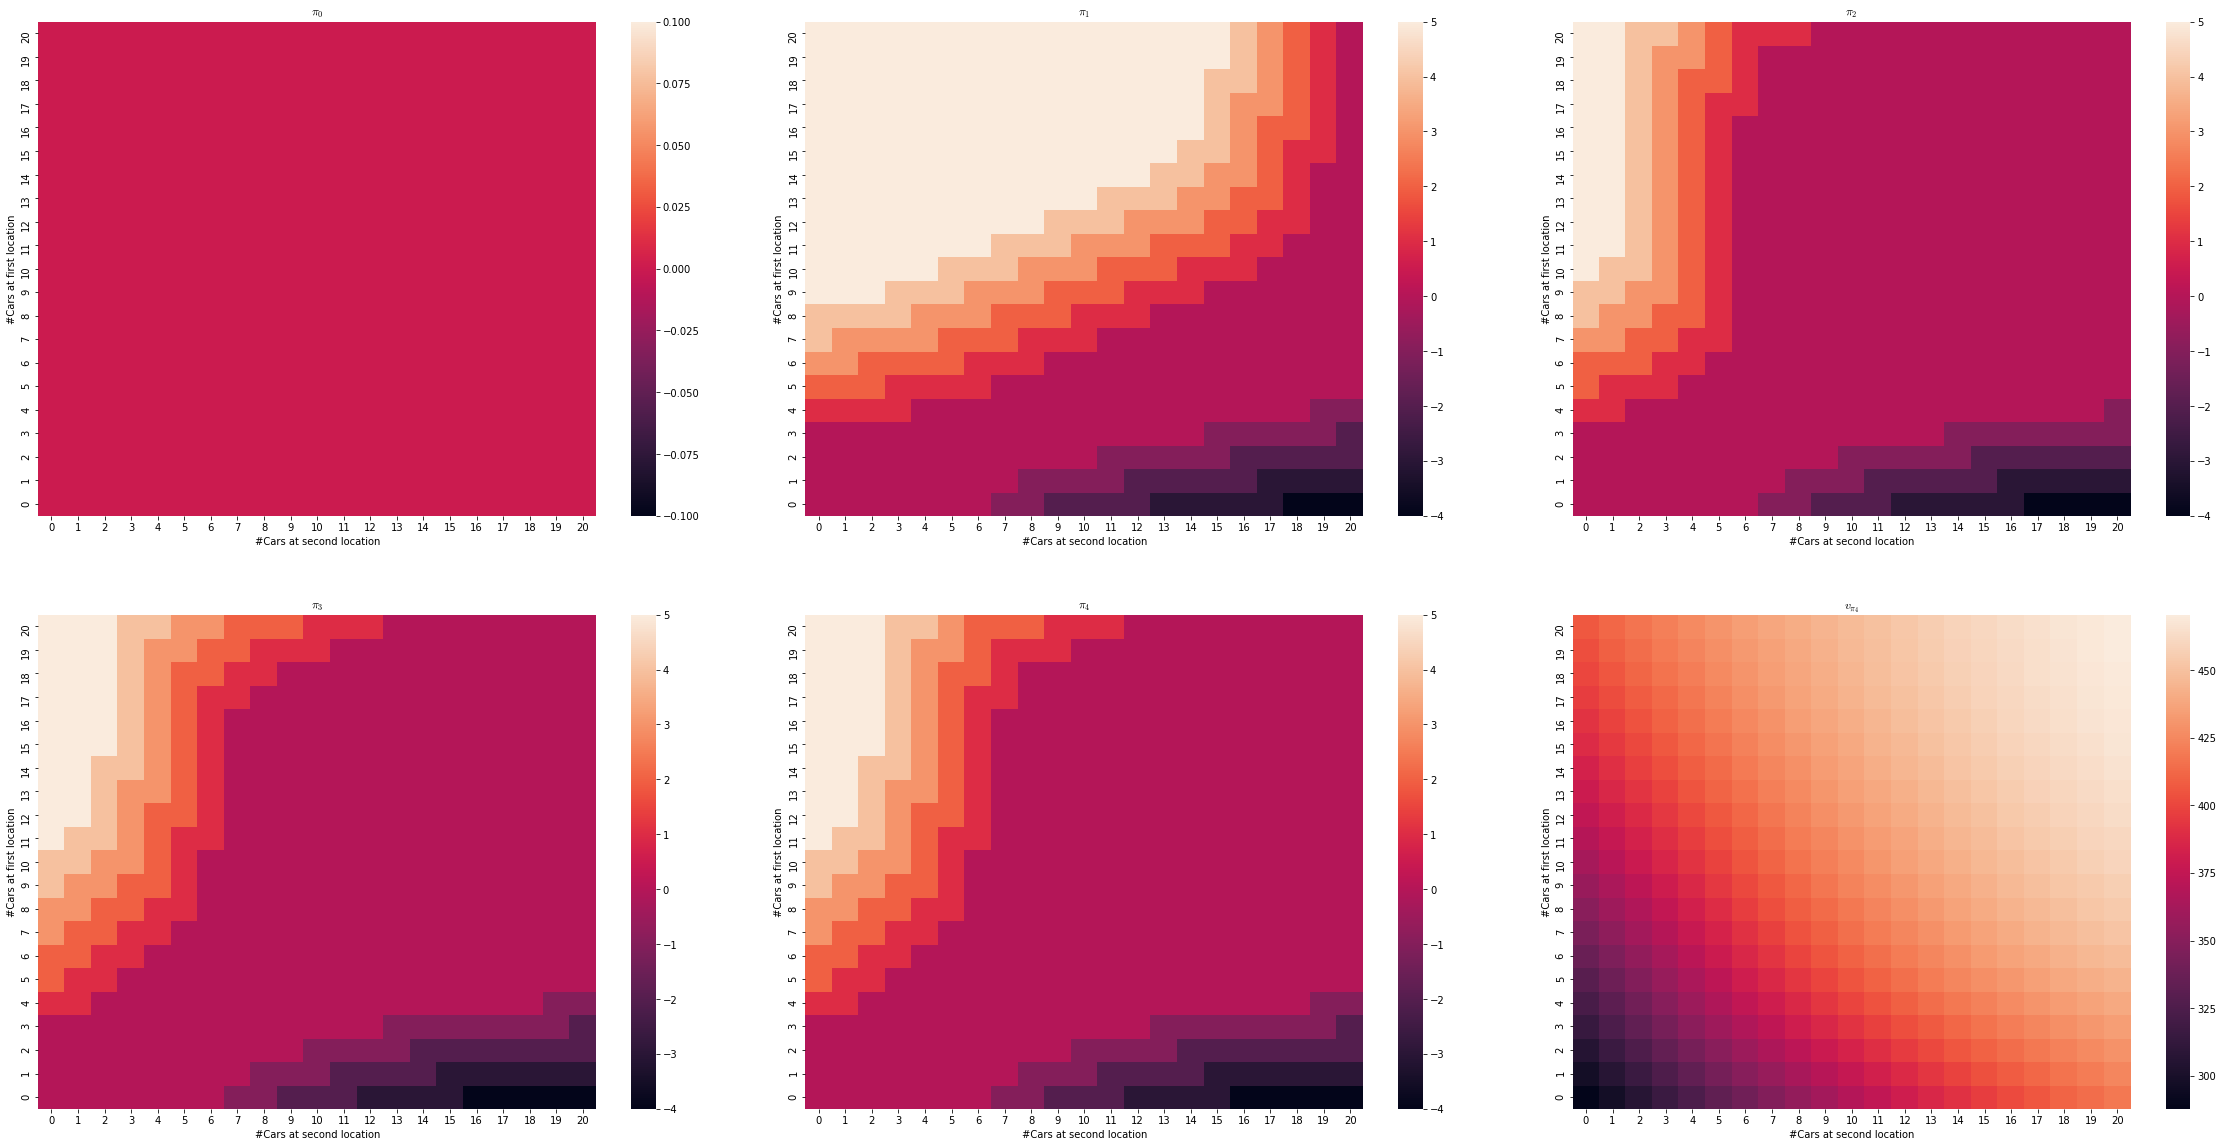

In [36]:
policy_iteration()